# Optimizing a Variational Autoencoder with Bayesian Optimization

Start with imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pystan import StanModel
from keras.datasets import mnist
from vae import VAE
from gp import GP
from scipy.stats import multivariate_normal as mvn
from scipy.spatial.distance import cdist

Using TensorFlow backend.


To implement Bayesian optimization of a black box function, we usually need the following ingredients:
* <b>A surrogate model.</b> A model of the black box function we want to optimize. The model shall return both the mean prediction as well as the predicted variance of the function values. A convenient model is the Gaussian Process (GP).
* <b>A covariance function (kernel)</b>. Gaussian Processes are defined with the mean function and the covariance function. A covariance function is a bivariate function that returns and estimate of the coavariance between two input points.
* <b>An acquisition function</b>. Combines the predicted mean and variance to reveal where to evaluate the black box function next. It is designed to trade-off <i>exploration</i> (regions of high variance - uncertainty) and <i>exploitation</i> (regions of high predicted mean value).

In [2]:
import sys
print(sys.executable)

/Users/martins/Dev/py3/bin/python


In [10]:
# Giphy data set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Original image dimension - need to reconstruct when plotting.
image_dim = (x_train.shape[1], x_train.shape[2])
original_dim = x_train.shape[1] * x_train.shape[2]

x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [129]:
def score_parameters(x_train, x_test, original_dim,
                     **kwargs):
    # Train the auto encoder
    # factory = VAE(original_dim=original_dim, **kwargs)
    # vae = factory.compile()
    # vae.fit(x_train,
    #        epochs=10,
    #        batch_size=30,
    #        validation_data=(x_test, None),
    #        verbose=True)
    # return factory, vae, vae.history.history["val_loss"][-1]
    # return [kwargs.get("intermediate_dim", 0)/1000.0]
    idim = kwargs.get("intermediate_dim", 0)
    return [(idim-500)**2 / (500**2)]
    
    
    

In [42]:
# Optimization parameters
n = 1000
delta = 3
iterations = 10
X = np.linspace(1, n, n).astype(int).reshape((n, 1))
look_x = np.random.choice(X.ravel(), delta, replace=False)

# Evaluate model for a sample of points
scores = [score_parameters(x_train,
                           x_test,
                           original_dim, intermediate_dim=x)[-1] for x in look_x]

look_x, scores

(array([749,  43, 806]), [0.749, 0.043, 0.806])

Let's defined the above model in STAN. The code is passed as a string, which is to be compiled.

In [163]:
stan_code = """

data {
  int<lower=1> N;       // Number of data points
  int<lower=1> D;       // Input space dimensionality
  matrix[N, D] X;       // Input design matrix
  vector[N] y;          // Target vector

  // Gamma hyperparameters
  real mu_noise;
  real sd_noise;
  real mu_signal;
  real sd_signal;
  real mu_lengthscale;
  real sd_lengthscale;
}

transformed data {
  vector[N] mu;
  for (i in 1:N) mu[i] = mean(y);
}

parameters {
  real log_lengthscale;
  real log_noise;
  real log_signal;
}

transformed parameters{
    real lengthscale;
    real noise;
    real signal;
    lengthscale = exp(log_lengthscale);
    noise = exp(log_noise);
    signal = exp(log_signal);
}

model {
    matrix[N, N] Sigma;
    log_noise ~ normal(mu_noise, sd_noise);
    log_signal ~ normal(mu_signal, sd_signal);
    log_lengthscale ~ normal(mu_lengthscale, sd_lengthscale);

    for (i in 1:N){
        for (j in 1:N){
            Sigma[i, j] = signal * exp(-square(1.0 / lengthscale) * square(dot_self(X[i] - X[j])));
        }
    }
    Sigma = Sigma + diag_matrix(rep_vector(noise, N));

    // GP
    y ~ multi_normal(mu, Sigma);
}
"""

In [164]:
sm = StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7e673c37d91c4628ff290f7785623f27 NOW.


$$ k(x, x') = \text{exp}(-\frac{\|x-x'\|^2}{\ell^2}) $$

In [151]:
def exponential_kernel(X, Y, bandwidth=1.0, lengthscale=1.0):
    """
        :param X: Array of shape (n_samples, n_features)
        :param Y: Array of shape (n_samples, n_features)
        :param bandwidth: (``float``) Bandwidth.
        :return: Kernel matrix between data points.
    """
    # return np.exp(-bandwidth * cdist(X, Y, metric="euclidean") ** 2)
    return np.exp(- cdist(X, Y, metric="euclidean") ** 2 / lengthscale ** 2)

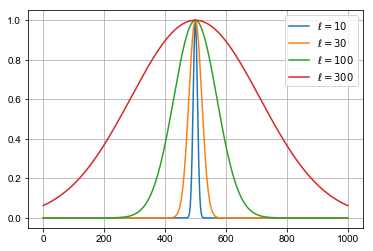

In [166]:
x0 = np.atleast_2d(500)

k_10 = exponential_kernel(X, x0, lengthscale=10)
k_30 = exponential_kernel(X, x0, lengthscale=30)
k_100 = exponential_kernel(X, x0, lengthscale=100)
k_300 = exponential_kernel(X, x0, lengthscale=300)

plt.figure()
plt.plot(X, k_10, "-", label="$\\ell=10$")
plt.plot(X, k_30, "-", label="$\\ell=30$")
plt.plot(X, k_100, "-", label="$\\ell=100$")
plt.plot(X, k_300, "-", label="$\\ell=300$")
plt.legend()
plt.grid()



In [205]:
# Prior hyperparameters
mu_noise = -4
sd_noise = 1
mu_signal = 1
sd_signal = 2


mu_lengthscale = 4
sd_lengthscale = 1.5



Here is a plot of the hyperparameter prior distributons.

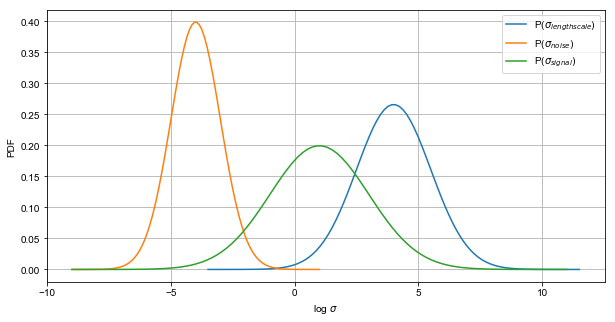

In [206]:
t_lengthscale = np.linspace(mu_lengthscale-5*sd_lengthscale, mu_lengthscale+5*sd_lengthscale, 100)
pdf_lengthscale = mvn.pdf(t_lengthscale, mean=mu_lengthscale, cov=sd_lengthscale**2)

t_noise = np.linspace(mu_noise-5*sd_noise, mu_noise+5*sd_noise, 100)
pdf_noise = mvn.pdf(t_noise, mean=mu_noise, cov=sd_noise**2)

t_signal = np.linspace(mu_signal-5*sd_signal, mu_signal+5*sd_signal, 100)
pdf_signal = mvn.pdf(t_signal, mean=mu_signal, cov=sd_signal**2)

plt.figure(figsize=(10, 5))
plt.plot(t_lengthscale, pdf_lengthscale, label="P($\\sigma_{lengthscale}$)")
plt.plot(t_noise, pdf_noise, label="P($\\sigma_{noise}$)")
plt.plot(t_signal, pdf_signal, label="P($\\sigma_{signal}$)")
plt.legend()
plt.xlabel("log $\\sigma$")
plt.ylabel("PDF")
plt.grid()
plt.show()

The plot is useful to convey information on what hyperparameter values we deem possible. Note that rather than fixed initial values, the inputs to the MCMC sampler are the prior distributions - the sampler will explore approximately within these bounds. 

An important thing to note is that we are setting the signal variance to be on average higher than the noise variance. This is to be expected if the underlying function contains any regularity at all.

Also important is the lengthscale distribution; The value of this parameter will determine the extent to which different values of the input space have influence on the scoring function.

In [192]:
def sample_hyperparameters(X, y, look_x):
    """ Sample hyperparameters with the Stan model. """
    fit = sm.sampling(data={"X": X[look_x], "y": y, "D": 1, "N": len(y),
                            "mu_noise": mu_noise,
                            "sd_noise": sd_noise,
                            "mu_signal": mu_signal,
                            "sd_signal": sd_signal,
                            "mu_lengthscale": mu_lengthscale,
                            "sd_lengthscale": sd_lengthscale,})
    noise_post = np.mean(fit["noise"])
    signal_post = np.mean(fit["signal"])
    lengthscale_post = np.mean(fit["lengthscale"])
    return noise_post, signal_post, lengthscale_post

y = np.array(scores)
noise_post, signal_post, lengthscale_post = sample_hyperparameters(X, y, look_x)

print("Noise variance (posterior mean): %.3f" % noise_post)
print("Signal variance (posterior mean): %.3f" % signal_post)
print("Lengthscale (posterior mean): %.3f"lengthscale % lengthscale_post)

/Users/martins/Dev/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Noise variance (posterior mean): 0.027
Signal variance (posterior mean): 0.034
Lengthscale (posterior mean): 139.193


In [194]:
def fit_gp(X, y, look_x, noise_var, signal_var, lengthscale):
    Kx = exponential_kernel(X, X, lengthscale=lengthscale)
    gp = GP(noise=noise_var, signal=signal_var)
    gp.fit(Kx[look_x, :][:, look_x], y)
    ym, yv = gp.predict(Kx[:, look_x], np.diagonal(Kx))
    return ym, yv
    
ym, yv = fit_gp(X, y, look_x, noise_post, signal_post, lengthscale_post)

In [195]:
def ei(mu, std, tau):
    """
    Calculate expected improvement.
    :param mu: mu(x)
    :param std: std(x)
    :param tau: lower bound.
    :return:
    """
    z = (mu.ravel() - tau) / std.ravel()
    return (mu.ravel() - tau) * mvn.cdf(z) + std.ravel() * mvn.pdf(z)


In [196]:
def compute_acquisition(ym, yv):
    """ Compute acquisition function and return next candidates """
    aq = ei(mu = -ym, std=np.sqrt(yv), tau=max(-ym))
    aq[look_x] = -np.inf
    imax = np.argmax(aq)
    return aq, imax

aq, imax = compute_acquisition(ym, yv)

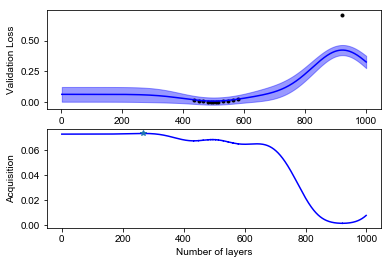

In [197]:
def plot_fit(X, y, look_x, ym, yv, aq, title=""):
    """ Plot the model fit and the acquisition function. """
    fig, ax = plt.subplots(nrows=2, ncols=1)
    ax[0].set_title(title)
    ax[0].plot(X[look_x], y, ".", color="black")
    ax[0].plot(X, ym, "-", color="blue")
    ax[0].fill_between(X.ravel(), ym.ravel()-yv.ravel(), ym.ravel()+yv.ravel(), color="blue", alpha=0.4)
    ax[0].set_ylabel("Validation Loss")
    ax[1].plot(aq, color="blue")
    ax[1].plot(imax, aq[imax], "*")
    ax[1].set_ylabel("Acquisition")
    ax[1].set_xlabel("Number of layers")
    

plot_fit(X, y, look_x, ym, yv, aq)

In [91]:
# Add to look-ahead and compute scores
look_x = np.array(list(look_x) + [imax])
sc = score_parameters(x_train, x_test, original_dim, intermediate_dim=X[imax, 0])[-1]
scores.append(sc)

In [92]:
look_x, scores

(array([749,  43, 806,  32,  18,  25,   5,  12,  13,  61]),
 [0.749, 0.043, 0.806, 0.033, 0.019, 0.026, 0.006, 0.013, 0.014, 0.062])

We are ready to define an iterative algorithm to optimize the model loss in a Bayesian optimization manner. The acquisition function dictates which point to select next, tradig off exploration and exploitation. The final recommendation --- the perceived optimum --- is taken to be the maximum of the related GP fit.

/Users/martins/Dev/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Step: 0	next point: 174	next score: 0.422
Step: 1	next point: 204	next score: 0.348
Step: 2	next point: 240	next score: 0.268
Step: 3	next point: 268	next score: 0.213
Step: 4	next point: 297	next score: 0.163
Step: 5	next point: 287	next score: 0.180
Step: 6	next point: 330	next score: 0.114
Step: 7	next point: 323	next score: 0.124
Step: 8	next point: 370	next score: 0.067
Step: 9	next point: 367	next score: 0.070


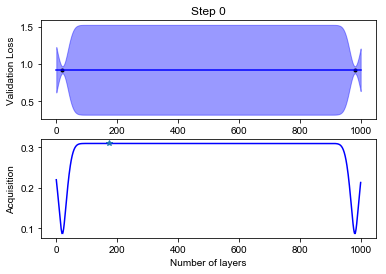

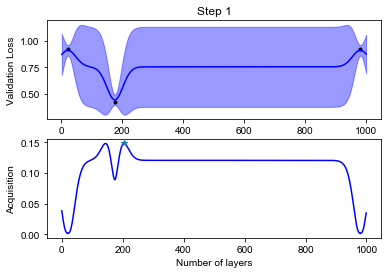

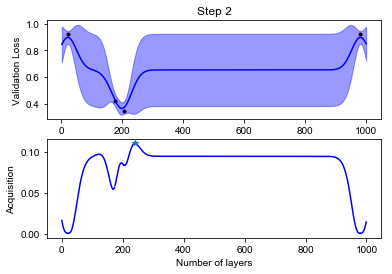

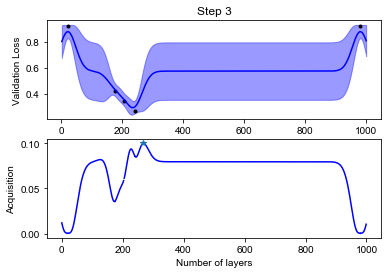

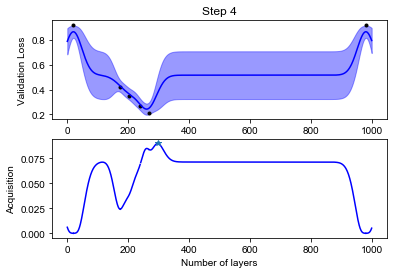

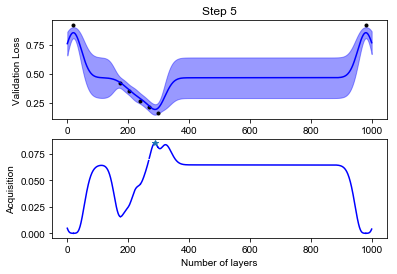

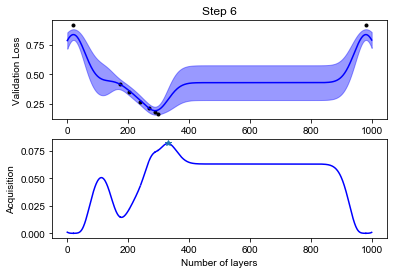

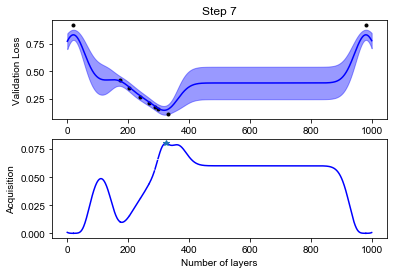

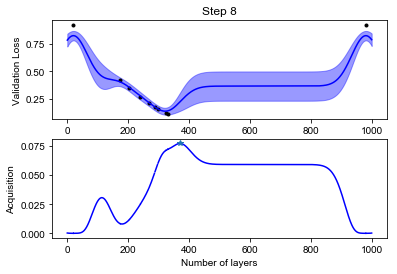

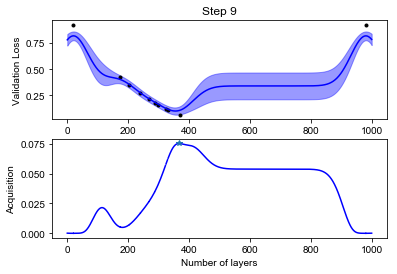

In [207]:

# Select delta initial evaluations
# look_x = np.random.choice(X.ravel(), delta, replace=False)
look_x = np.array([20, 980])
scores = np.array([score_parameters(x_train, x_test, original_dim, intermediate_dim=x)[-1] 
                   for x in look_x])

# Iterate 10 time
for step in range(10):
    noise_post, signal_post, lengthscale_post = sample_hyperparameters(X, scores, look_x)
    ym, yv = fit_gp(X, scores, look_x, noise_post, signal_post, lengthscale_post)
    aq, imax = compute_acquisition(ym, yv)

    plot_fit(X, scores, look_x, ym, yv, aq, title="Step %d" % step)

    iscore = score_parameters(x_train, x_test, original_dim, intermediate_dim=X[imax, 0])[-1]
    look_x = np.array(list(look_x) + [imax])
    scores = np.array(list(scores) + [iscore])
    
    print("Step: %d\tnext point: %d\tnext score: %.3f" % (step, imax, iscore))
